In [1]:
# default_exp analyses

# Repetition Effects

When it comes to repetition effects, Lohnas (2014) and perhaps other sources establish a few other benchmark phenomena that deserve accounting for. We include functionality for measuring these phenomena here.

In [8]:
from compmemlearn.datasets import prepare_lohnas2014_data, prepare_howakaha05_data

trials, events, list_length, presentations, list_types, rep_data, subjects = prepare_howakaha05_data(
    '../data/HowaKaha05.dat')
    
trials, events, list_length, presentations, list_types, rep_data, subjects = prepare_lohnas2014_data(
    '../data/repFR.mat')

events.head()

,subject,list,item,input,output,study,recall,repeat,intrusion,condition
0,1,1,0,1,1.0,True,True,0,False,4
1,1,1,1,2,2.0,True,True,0,False,4
2,1,1,2,3,3.0,True,True,0,False,4
3,1,1,3,4,4.0,True,True,0,False,4
4,1,1,4,5,5.0,True,True,0,False,4


## Controlling for Serial Position
To control for serial position effects of repeated items, analyses are often performed on randomized recall sequences with recall probabilities matched to the serial position curve of controls lists.  Recall of each item is then calculated randomly and independently across trials. 

In [2]:
# export

from numba import njit, prange
import numpy as np

@njit(parallel=True)
def randomize_dataset(recall_rate_by_serial_position, sample_size):
    """
    To control for serial position effects of repeated items, analyses are often performed on randomized recall sequences with recall probabilities matched to the serial position curve of controls lists. Recall of each item is then calculated randomly and independently across trials. 
    """

    samples = np.random.rand(sample_size, len(recall_rate_by_serial_position)) < recall_rate_by_serial_position
    result = np.zeros((sample_size, len(recall_rate_by_serial_position)))

    for i in prange(sample_size):
        sample = samples[i].nonzero()[0] + 1
        np.random.shuffle(sample)
        result[i, :len(sample)] = sample

    return result


In [ ]:
recall_rates = events.pivot_table(index='input', values='recall').to_numpy().flatten()

randomize_dataset(recall_rates, 10000000)

## Recall Probability by Lag
NOTE: this version is deprecated and only maintained to aid updating the codebase; see devoted notebook "recall probability by spacing" for the much (>5x) faster replacement

In [9]:
from numba import njit
import numpy as np

@njit(fastmath=True, nogil=True)
def recall_probability_by_lag(presentations, study_positions_in_recall_order, experiment_count=1):

    presented, retrieved = np.zeros(5), np.zeros(5)

    for trial_index, sequence in enumerate(presentations):

        for experiment in range(experiment_count):
            
            # retrieve trial information
            trial = study_positions_in_recall_order[trial_index*experiment_count + experiment]

            # extract list of recalled items
            recalled = sequence[trial-1][trial != 0]
            

            for item in np.unique(sequence):
                locations = np.where(sequence == item)[0]

                # presented just once
                if len(locations) == 1:
                    index = 0
                else: 

                    # no intervening items (massed)
                    lag = locations[1] - locations[0] - 1
                    if lag == 0:
                        index = 1

                    # 1-2 intervening items
                    elif lag <= 2:
                        index = 2

                    # 3-5
                    elif lag <= 5:
                        index = 3

                    # 6-8
                    else:
                        index = 4

                presented[index] += 1
                retrieved[index] += item in recalled
        
    return retrieved, presented, retrieved/presented

[0.37278912 0.43928571 0.47678571 0.55714286 0.57857143]
[0.0664966  0.0375     0.08035714 0.02142857]


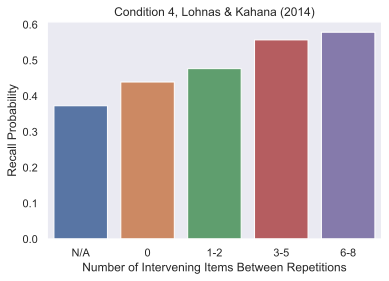

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
%config InlineBackend.figure_formats = ['svg']

sns.set_theme(style="dark")
condition = 4
source = 'Lohnas & Kahana (2014)'

result = recall_probability_by_lag(presentations[list_types>=condition], trials[list_types>=condition])[-1]
print(result)
print(result[1:] - result[:-1])
ax = sns.barplot(x=['N/A', '0', '1-2', '3-5', '6-8'], 
                 y=result)
plt.xlabel('Number of Intervening Items Between Repetitions')
plt.ylabel('Recall Probability')
plt.title('Condition {}, {}'.format(condition, source))
plt.show()

In [ ]:
# export
from compmemlearn.models import Classic_CMR
from numba import int64

@njit(fastmath=True, nogil=True)
def sim_recall_probability_by_lag(presentations, experiment_count, encoding_drift_rate,         
    start_drift_rate, recall_drift_rate, shared_support, item_support, learning_rate, 
    primacy_scale, primacy_decay, stop_probability_scale, 
    stop_probability_growth, choice_sensitivity, delay_drift_rate, drift_familiarity_scale, mfc_familiarity_scale, 
    mcf_familiarity_scale, sampling_rule):
    """
    Apply organizational analyses to visually compare the behavior of the model 
    with these parameters against specified dataset.
    """
    
    max_lag = 8
    total_ratio = np.zeros(max_lag+2)
    total_count = 0
    
    # generate simulation data from model
    for experiment in range(experiment_count):

        sim = np.zeros(np.shape(presentations), dtype=int64) # set as int64 when using numba, int otherwise
        for trial_index in range(len(presentations)):
            presentation = presentations[trial_index]
            
            item_count = np.max(presentation)+1
            model = Classic_CMR( item_count, len(presentations),  encoding_drift_rate,         
                start_drift_rate, recall_drift_rate, shared_support, item_support, learning_rate, 
                primacy_scale, primacy_decay, stop_probability_scale, 
                stop_probability_growth, choice_sensitivity, delay_drift_rate, drift_familiarity_scale, 
                 mfc_familiarity_scale, mcf_familiarity_scale, sampling_rule)

            # simulate study events
            model.experience(np.eye(model.item_count, model.item_count)[presentation])
            
            # simulate and collect sequence of recalled item indices
            recalled = model.free_recall()
            xsorted = np.argsort(presentation)
            ypos = np.searchsorted(presentation[xsorted], recalled)
            sim[trial_index, :len(recalled)] = xsorted[ypos]+1
            
        total_ratio += recall_probability_by_lag(presentations, sim)
        total += 1
        
    return total_ratio/total

## OR Score
Given that the probability of recalling an item repeated in positions i and j is equivalent to the probability of recalling either the occurrence of the item in position i or the occurrence of the item in position j, contextual variability predicts that the probability of recalling either of two once-presented items in positions i and j, termed the OR score, should increase with their spacing |i - j|.

To control for serial position effects of repeated items, they determined OR scores from randomized recall sequences with recall probabilities matched to the serial position curve of controls lists. They subtracted the OR scores based on these randomized recall sequences from the observed OR scores, and for illustrative purposes added the mean randomized OR score at each lag.

In [ ]:
#TBD

## Rate of transition between items that follow presentation of the same item
They considered transitions between items following a shared repeated item. They calculated the proportion of those items recalled in $S_j = {j + 1, j + 2}$ of which CMR then recalled an item in the set $S_i = {i + 1, i + 2}$. They also calculated the proportion of recalls $S_i$ of which CMR then transitioned to an item in the set $S_j$. They calculated the proportion of transitions for each of lags $j - i >= 4$, and represented the mean percent of transitions across these lags. 

To estimate the proportion of transitions that CMR would make at these lags in the absence of repeated items, they considered transitions in control lists matched to the same serial positions considered in the mixed lists. They matched these serial positions to 100 random shuffles of the control lists, and took the mean across the reshuffled datasets.

In [ ]:
#TBD

## How Do Values of $\zeta_s$ Configure Temporal Contiguity With Secondary Item Presentations?
Weights in $M^{CF}$ do not just configure the overall probability of recalling an item. Since the state of context depends on prior items encoded or retrieved and  $M^{CF}$ encodes context-to-item associations, differences in $M^{CF}$ learning rates for presentations of an item as enforced by the differential encoding mechanism must also the rate of transition between different items during recall.

In particular, weaker learning for the second presentation of a repeated item compared to the first should enforce greater rate of transitions between the repeated item and other items presented near its first presentation.

In [2]:
# export

import pandas as pd
import numpy as np

def indices_of_repeated_items(presentation_sequence):

    values, counts = np.unique(presentation_sequence, return_counts=True)
    repeated_items = {v: np.where(presentation_sequence == v)[0] for v in values if counts[v] > 1}

    return {key:repeated_items[key] for key in repeated_items}

    
def alternative_contiguity_test(mixed_presentations, mixed_recalls, lag_threshold, repetition_count):
    relevant_lags = list(range(-int(lag_threshold/2), int(lag_threshold/2+1)))
    del relevant_lags[int(lag_threshold/2)]

    actual_lags = [[0 for each in relevant_lags] for i in range(repetition_count)]
    possible_lags = [[0 for each in relevant_lags] for i in range(repetition_count)]

    for trial_index in range(len(mixed_presentations)):

        # sequence of item indices ordered as they were studied
        presentation = mixed_presentations[trial_index]

        # sequence of initial study positions ordered as they were recalled
        trial_by_study_position = mixed_recalls[trial_index]

        # sequence of item indices ordered as they were recalled
        trial_by_item_index = presentation[trial_by_study_position-1][:np.size(np.nonzero(trial_by_study_position))]

        # {item_index: [presentation indices]} for each repeated item in presentation sequence spaced by >4 items
        i_and_j = indices_of_repeated_items(presentation)
        
        # then for each unique repeated item in the study list, 
        for repeated_item in i_and_j:

            # search for relevant item(s) in recall sequence and skip if not found 
            look_for = trial_by_item_index == presentation[i_and_j[repeated_item][0]]
            for k in range(1, repetition_count):
                look_for = np.logical_or(
                    look_for, trial_by_item_index == presentation[i_and_j[repeated_item][k]])
            recall_positions = np.where(look_for)[0]

            if np.size(recall_positions) == 0:
                continue

            # check each position the item was observed (always just 1 position; we loop for parallelism w control)
            for recall_position in recall_positions:

                # also skip if no successive recall was made, 
                if np.size(trial_by_item_index) == recall_position + 1:
                    continue

                # build list of study positions for items recalled up to repeated item
                prior_lags = [[] for each in range(repetition_count)]
                for i in range(recall_position):

                    # if considered item is also repeated, we track lags wrt to all presentations
                    if trial_by_item_index[i] in i_and_j:
                        for considered in range(len(i_and_j[trial_by_item_index[i]])):
                            for focal in range(repetition_count):
                                prior_lags[focal].append(
                                    int(i_and_j[trial_by_item_index[i]][considered] - i_and_j[repeated_item][focal]))
                    else:
                        for k in range(repetition_count):
                            prior_lags[k].append(int(trial_by_study_position[i] - i_and_j[repeated_item][k]))

                # transition of a given lag is possible if lag not present in prior_lags
                for lag in relevant_lags:
                    for k in range(repetition_count):
                        
                        # skip increment if i_and_j[repeated_item][k] - i_and_j[repeated_item][-1] < lag_threshold
                        if (k > 0) and (i_and_j[repeated_item][k] - i_and_j[repeated_item][k-1] < lag_threshold):
                            continue
                        
                        if lag not in prior_lags[k]:
                            possible_lags[k][relevant_lags.index(lag)] += 1

                # track each serial lag of actually transitioned-to item
                if trial_by_item_index[recall_position+1] in i_and_j:
                    positions = i_and_j[trial_by_item_index[recall_position+1]]
                    for transition_study_position in positions:
                        for k in range(repetition_count):

                            # skip increment if i_and_j[repeated_item][k] - i_and_j[repeated_item][k-1] < lag_threshold
                            if (k > 0) and (i_and_j[repeated_item][k] - i_and_j[repeated_item][k-1] < lag_threshold):
                                continue

                            lag = int(transition_study_position - i_and_j[repeated_item][k])
                            if lag in relevant_lags:
                                actual_lags[k][relevant_lags.index(lag)] += 1
                else:
                    transition_study_position = trial_by_study_position[recall_position+1]-1
                    for k in range(repetition_count):

                        # skip increment if i_and_j[repeated_item][k] - i_and_j[repeated_item][k-1] < lag_threshold
                        if (k > 0) and (i_and_j[repeated_item][k] - i_and_j[repeated_item][k-1] < lag_threshold):
                            continue

                        lag = int(transition_study_position-i_and_j[repeated_item][k])
                        if lag in relevant_lags:
                            actual_lags[k][relevant_lags.index(lag)] += 1

    result = []
    for k in range(repetition_count):
        
        for i in range(len(possible_lags[k])):
            if possible_lags[k][i] == 0:
                possible_lags[k][i] += 1

        result.append(pd.DataFrame(
            {'lag': relevant_lags, 'prob': np.divide(actual_lags[k], possible_lags[k]), 
            'actual': actual_lags[k], 'possible': possible_lags[k]}))

    return pd.concat(result, keys=['From Position {}'.format(i+1) for i in range(repetition_count)], names=['locus'])


def alternative_contiguity_control(
    mixed_presentations, control_presentations, control_recalls, lag_threshold, repetition_count):
    relevant_lags = list(range(-int(lag_threshold/2), int(lag_threshold/2+1)))
    del relevant_lags[int(lag_threshold/2)]

    actual_lags = [[0 for each in relevant_lags] for i in range(repetition_count)]
    possible_lags = [[0 for each in relevant_lags] for i in range(repetition_count)]

    for trial_index in range(len(mixed_presentations)):

        # sequence of item indices ordered as they were studied
        presentation = mixed_presentations[trial_index]
        control_presentation = control_presentations[trial_index]

        # sequence of initial study positions ordered as they were recalled
        trial_by_study_position = control_recalls[trial_index]

        # sequence of item indices ordered as they were recalled
        trial_by_item_index = control_presentation[trial_by_study_position-1][:np.size(np.nonzero(trial_by_study_position))]

        # {item_index: [presentation indices]} for each repeated item in presentation sequence spaced by >4 items
        i_and_j = indices_of_repeated_items(presentation)
        
        # then for each unique repeated item in the study list, 
        for repeated_item in i_and_j:

            # search for relevant item(s) in recall sequence and skip if not found 
            look_for = trial_by_item_index == control_presentation[i_and_j[repeated_item][0]]
            for k in range(1, repetition_count):
                look_for = np.logical_or(
                    look_for, trial_by_item_index == control_presentation[i_and_j[repeated_item][k]])
            recall_positions = np.where(look_for)[0]

            for recall_position in recall_positions:

                # also skip if no successive recall was made, 
                if np.size(trial_by_item_index) == recall_position + 1:
                    continue

                # build list of study positions for items recalled up to repeated item
                prior_lags = [[] for each in range(repetition_count)]
                for i in range(recall_position):
                    if trial_by_item_index[i] in i_and_j:
                        for considered in range(len(i_and_j[trial_by_item_index[i]])):
                            for focal in range(repetition_count):
                                prior_lags[focal].append(
                                    int(i_and_j[trial_by_item_index[i]][considered] - i_and_j[repeated_item][focal]))
                    else:
                        for k in range(repetition_count):
                            prior_lags[k].append(int(trial_by_study_position[i] - i_and_j[repeated_item][k]))

                # transition of a given lag is possible if lag not present in prior_lags
                for lag in relevant_lags:
                    for k in range(repetition_count):
                        if lag not in prior_lags[k]:
                            possible_lags[k][relevant_lags.index(lag)] += 1

                # track each serial lag of actually transitioned-to item
                if trial_by_item_index[recall_position+1] in i_and_j:
                    positions = i_and_j[trial_by_item_index[recall_position+1]]
                    for transition_study_position in positions:
                        for k in range(repetition_count):
                            lag = int(transition_study_position - i_and_j[repeated_item][k])
                            if lag in relevant_lags:
                                actual_lags[k][relevant_lags.index(lag)] += 1
                else:
                    transition_study_position = trial_by_study_position[recall_position+1]-1
                    for k in range(repetition_count):
                        lag = int(transition_study_position-i_and_j[repeated_item][k])
                        if lag in relevant_lags:
                            actual_lags[k][relevant_lags.index(lag)] += 1

    result = []
    for k in range(repetition_count):
        result.append(pd.DataFrame(
            {'lag': relevant_lags, 'prob': np.divide(actual_lags[k], possible_lags[k]), 
            'actual': actual_lags[k], 'possible': possible_lags[k]}))

    return pd.concat(result, keys=['From Position {}'.format(i+1) for i in range(repetition_count)], names=['locus'])

def sim_alternative_contiguity_test(presentations, experiment_count, lag_threshold, repetition_count, encoding_drift_rate,         
    start_drift_rate, recall_drift_rate, shared_support, item_support, learning_rate, 
    primacy_scale, primacy_decay, stop_probability_scale, 
    stop_probability_growth, choice_sensitivity, delay_drift_rate, 
    drift_familiarity_scale, mfc_familiarity_scale, mcf_familiarity_scale, sampling_rule):
    """
    Apply organizational analyses to visually compare the behavior of the model 
    with these parameters against specified dataset.
    """

    results = []
    # generate simulation data from model
    for experiment in range(experiment_count):

        sim = np.zeros(np.shape(presentations), dtype=int)
        for trial_index in range(len(presentations)):
            presentation = presentations[trial_index]
            
            item_count = np.max(presentation)+1
            model = Classic_CMR( item_count, len(presentations),  encoding_drift_rate,         
                start_drift_rate, recall_drift_rate, shared_support, item_support, learning_rate, 
                primacy_scale, primacy_decay, stop_probability_scale, 
                stop_probability_growth, choice_sensitivity, delay_drift_rate, drift_familiarity_scale, 
                 mfc_familiarity_scale, mcf_familiarity_scale, sampling_rule)

            # simulate study events
            model.experience(np.eye(model.item_count, model.item_count)[presentation])
            
            # simulate and add recall events to trials array
            recalled = model.free_recall()
            xsorted = np.argsort(presentation)
            ypos = np.searchsorted(presentation[xsorted], recalled)
            sim[trial_index, :len(recalled)] = xsorted[ypos]+1

        # apply contiguity test
        results.append(alternative_contiguity_test(presentations, sim, lag_threshold, repetition_count))

    return pd.concat(results, keys=list(range(experiment_count)), names=['experiment']).reset_index()

In [37]:
minimum_lag = 6
repetition_count = 2

individual_results = []

for subject in np.unique(subjects):
    selection = np.logical_and(list_types > 3, subjects == subject)

    individual_results.append(
        alternative_contiguity_test(presentations[selection], trials[selection], minimum_lag, repetition_count))

df = pd.concat(individual_results, keys=np.unique(subjects), names=['subject']).reset_index()
df.drop(['level_2'], axis=1, inplace=True)
df

,subject,locus,lag,prob,actual,possible
0,1,From Position 1,-3,0.000000,0,27
1,1,From Position 1,-2,0.115385,3,26
2,1,From Position 1,-1,0.153846,4,26
3,1,From Position 1,1,0.200000,8,40
4,1,From Position 1,2,0.314286,11,35
...,...,...,...,...,...,...
415,37,From Position 2,-2,0.125000,1,8
416,37,From Position 2,-1,0.142857,1,7
417,37,From Position 2,1,0.333333,2,6
418,37,From Position 2,2,0.000000,0,9


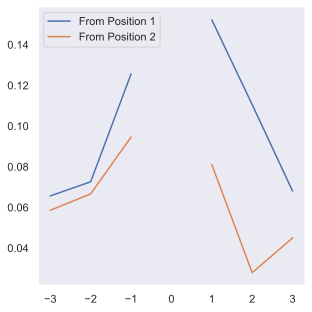

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt

max_lag = minimum_lag/2
filt_neg = f'{-max_lag} <= lag < 0'
filt_pos = f'0 < lag <= {max_lag}'

g = sns.FacetGrid(df, height=4.5)
g.map_dataframe(
    lambda data, **kws: sns.lineplot(
        data=data.query(filt_neg), x='lag', y='prob', hue='locus', err_style=None,**kws)
)

g.map_dataframe(
    lambda data, **kws: sns.lineplot(
        data=data.query(filt_pos), x='lag', y='prob', hue='locus', err_style=None, **kws)
)

plt.legend(['From Position {}'.format(i+1) for i in range(repetition_count)], loc='upper left')
#plt.title('Stronger Contiguity For First Presentation of an Item\n(Minimum Lag = {})'.format(minimum_lag))
plt.tight_layout()

### Control Version
How do we modify this for control lists? 
- Still use presentation vectors from mixed lists to define i_and_j, but use control list presentations and data for trial_by_study_position and trial_by_item_index and recall_position (except for i_and_j keys and values)
- Don't continue if trial_by_item_index[recall_position+1] in i_and_j

In [53]:
from tqdm import tqdm

individual_results = []

for iteration in tqdm(range(1000)):
    for subject in np.unique(subjects):
        mixed_selection = np.logical_and(list_types == 4, subjects == subject)
        control_selection = np.logical_and(list_types == 1, subjects == subject)
        shuffled_trials = trials[control_selection]
        np.random.shuffle(shuffled_trials)

        individual_results.append(
            alternative_contiguity_control(presentations[mixed_selection], presentations[control_selection], shuffled_trials, minimum_lag))

df = pd.concat(individual_results, keys=np.unique(subjects), names=['subject']).reset_index()
df.drop(['level_2'], axis=1, inplace=True)
df

 77%|███████▋  | 766/1000 [01:58<00:36,  6.37it/s]C:\Users\gunnj\AppData\Local\Temp/ipykernel_7552/90211409.py:169: RuntimeWarning: invalid value encountered in true_divide
  {'lag': relevant_lags, 'prob': np.divide(actual_lagsB, possible_lagsB),
 87%|████████▋ | 872/1000 [02:14<00:19,  6.63it/s]C:\Users\gunnj\AppData\Local\Temp/ipykernel_7552/90211409.py:166: RuntimeWarning: invalid value encountered in true_divide
  {'lag': relevant_lags, 'prob': np.divide(actual_lagsA, possible_lagsA),
100%|██████████| 1000/1000 [02:33<00:00,  6.50it/s]


,subject,locus,lag,prob,actual,possible
0,1,From First Position,-3,0.000000,0,13
1,1,From First Position,-2,0.047619,1,21
2,1,From First Position,-1,0.050000,1,20
3,1,From First Position,1,0.230769,6,26
4,1,From First Position,2,0.047619,1,21
...,...,...,...,...,...,...
415,37,From Second Position,-2,0.000000,0,7
416,37,From Second Position,-1,0.000000,0,7
417,37,From Second Position,1,0.000000,0,7
418,37,From Second Position,2,0.000000,0,6


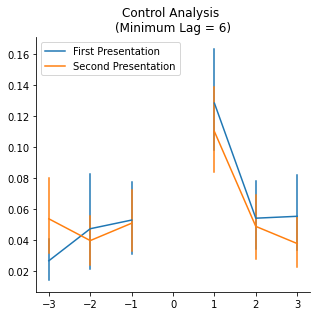

In [54]:
import seaborn as sns
import matplotlib.pyplot as plt

max_lag = minimum_lag/2
filt_neg = f'{-max_lag} <= lag < 0'
filt_pos = f'0 < lag <= {max_lag}'

g = sns.FacetGrid(df, height=4.5)
g.map_dataframe(
    lambda data, **kws: sns.lineplot(
        data=data.query(filt_neg), x='lag', y='prob', hue='locus', err_style='bars', **kws)
)

g.map_dataframe(
    lambda data, **kws: sns.lineplot(
        data=data.query(filt_pos), x='lag', y='prob', hue='locus', err_style='bars', **kws)
)

plt.legend(['First Presentation', 'Second Presentation'], loc='upper left')
plt.title('Control Analysis \n(Minimum Lag = {})'.format(minimum_lag))
plt.tight_layout()

## Recall Rate by Lag From Repetitions

In [10]:
def recall_rate_by_lag(mixed_presentations, mixed_recalls, lag_threshold, lag):
    """
    Find each item repetition in mixed_presentations and compute the recall rate for items at specified lag from each presentation position. Return the rate relative to the first presentation of each item and relative to the second.
    """

    recalls_A = 0
    recalls_B = 0
    total = 0

    for trial_index in range(len(mixed_presentations)):

        # sequence of item indices ordered as they were studied
        presentation = mixed_presentations[trial_index]

        # sequence of initial study positions ordered as they were recalled
        trial_by_study_position = mixed_recalls[trial_index]

        # sequence of item indices ordered as they were recalled
        trial_by_item_index = presentation[trial_by_study_position-1][:np.size(np.nonzero(trial_by_study_position))]

        # {item_index: [presentation indices]} for each repeated item in presentation sequence spaced by >4 items
        i_and_j = indices_of_repeated_items(presentation, lag_threshold)
        
        # then for each unique repeated item in the study list, 
        for repeated_item in i_and_j:

            # get the indices of neighbors to each presentation
            neighborA = presentation[i_and_j[repeated_item][0] + lag]
            neighborB = presentation[i_and_j[repeated_item][1] + lag]

            # skip if the neighbor is also a repeatedly presented item
            if (neighborA in i_and_j) or (neighborB in i_and_j):
                continue

            # track if they were recalled
            recalls_A += np.any(neighborA == trial_by_item_index)
            recalls_B += np.any(neighborB == trial_by_item_index)
            total += 1

    return recalls_A/total, recalls_B/total, total

In [31]:
individual_resultsA = []
individual_resultsB = []

for subject in np.unique(subjects):
    selection = np.logical_and(list_types > 2, subjects == subject)

    result = recall_rate_by_lag(presentations[selection], trials[selection], 4, 1)
    individual_resultsA.append(result[0])
    individual_resultsB.append(result[1])

np.mean(individual_resultsA), np.mean(individual_resultsB)

(0.3857720129269049, 0.382558043145297)